**İMPORT KUTUPHANE VE METRİKLER**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

warnings.filterwarnings("ignore")

DRİVE **BAĞLANTISI**

**OKUMA**

In [2]:
df = pd.read_csv("web-page-phishing.csv" , sep=",", encoding='utf-8')

In [3]:
df.head()

,url_length,n_dots,n_hypens,n_underline,n_slash,n_questionmark,n_equal,n_at,n_and,n_exclamation,n_space,n_tilde,n_comma,n_plus,n_asterisk,n_hastag,n_dollar,n_percent,n_redirection,phishing
0,37,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,77,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,126,4,1,2,0,1,3,0,2,0,0,0,0,0,0,0,0,0,1,1
3,18,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,55,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100077 entries, 0 to 100076
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   url_length      100077 non-null  int64
 1   n_dots          100077 non-null  int64
 2   n_hypens        100077 non-null  int64
 3   n_underline     100077 non-null  int64
 4   n_slash         100077 non-null  int64
 5   n_questionmark  100077 non-null  int64
 6   n_equal         100077 non-null  int64
 7   n_at            100077 non-null  int64
 8   n_and           100077 non-null  int64
 9   n_exclamation   100077 non-null  int64
 10  n_space         100077 non-null  int64
 11  n_tilde         100077 non-null  int64
 12  n_comma         100077 non-null  int64
 13  n_plus          100077 non-null  int64
 14  n_asterisk      100077 non-null  int64
 15  n_hastag        100077 non-null  int64
 16  n_dollar        100077 non-null  int64
 17  n_percent       100077 non-null  int64
 18  n_re

In [5]:
df.isnull().sum()/df.shape[0]

url_length        0.0
n_dots            0.0
n_hypens          0.0
n_underline       0.0
n_slash           0.0
n_questionmark    0.0
n_equal           0.0
n_at              0.0
n_and             0.0
n_exclamation     0.0
n_space           0.0
n_tilde           0.0
n_comma           0.0
n_plus            0.0
n_asterisk        0.0
n_hastag          0.0
n_dollar          0.0
n_percent         0.0
n_redirection     0.0
phishing          0.0
dtype: float64

**VERİ DEĞER ARALIĞINI KUCULTME**

In [6]:
df.columns.tolist()


['url_length',
 'n_dots',
 'n_hypens',
 'n_underline',
 'n_slash',
 'n_questionmark',
 'n_equal',
 'n_at',
 'n_and',
 'n_exclamation',
 'n_space',
 'n_tilde',
 'n_comma',
 'n_plus',
 'n_asterisk',
 'n_hastag',
 'n_dollar',
 'n_percent',
 'n_redirection',
 'phishing']

In [7]:
df.describe()

,url_length,n_dots,n_hypens,n_underline,n_slash,n_questionmark,n_equal,n_at,n_and,n_exclamation,n_space,n_tilde,n_comma,n_plus,n_asterisk,n_hastag,n_dollar,n_percent,n_redirection,phishing
count,100077.000000,100077.000000,100077.000000,100077.000000,100077.000000,100077.000000,100077.000000,100077.000000,100077.000000,100077.000000,100077.000000,100077.000000,100077.000000,100077.000000,100077.000000,100077.000000,100077.000000,100077.000000,100077.000000,100077.000000
mean,39.177683,2.224397,0.405188,0.137724,1.135386,0.024391,0.215834,0.022143,0.143330,0.002608,0.004876,0.003617,0.002378,0.002468,0.004097,0.000450,0.001899,0.109286,0.361532,0.363340
std,47.971847,1.255046,1.285465,0.723995,1.828526,0.167789,0.959802,0.268393,0.913656,0.082207,0.144569,0.078500,0.079558,0.104382,0.284046,0.058028,0.097412,1.695327,0.775492,0.480964
min,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,18.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,44.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,4165.000000,24.000000,43.000000,21.000000,44.000000,9.000000,23.000000,43.000000,26.000000,10.000000,18.000000,5.000000,11.000000,19.000000,60.000000,13.000000,10.000000,174.000000,17.000000,1.000000


Koralasyon Matrixi

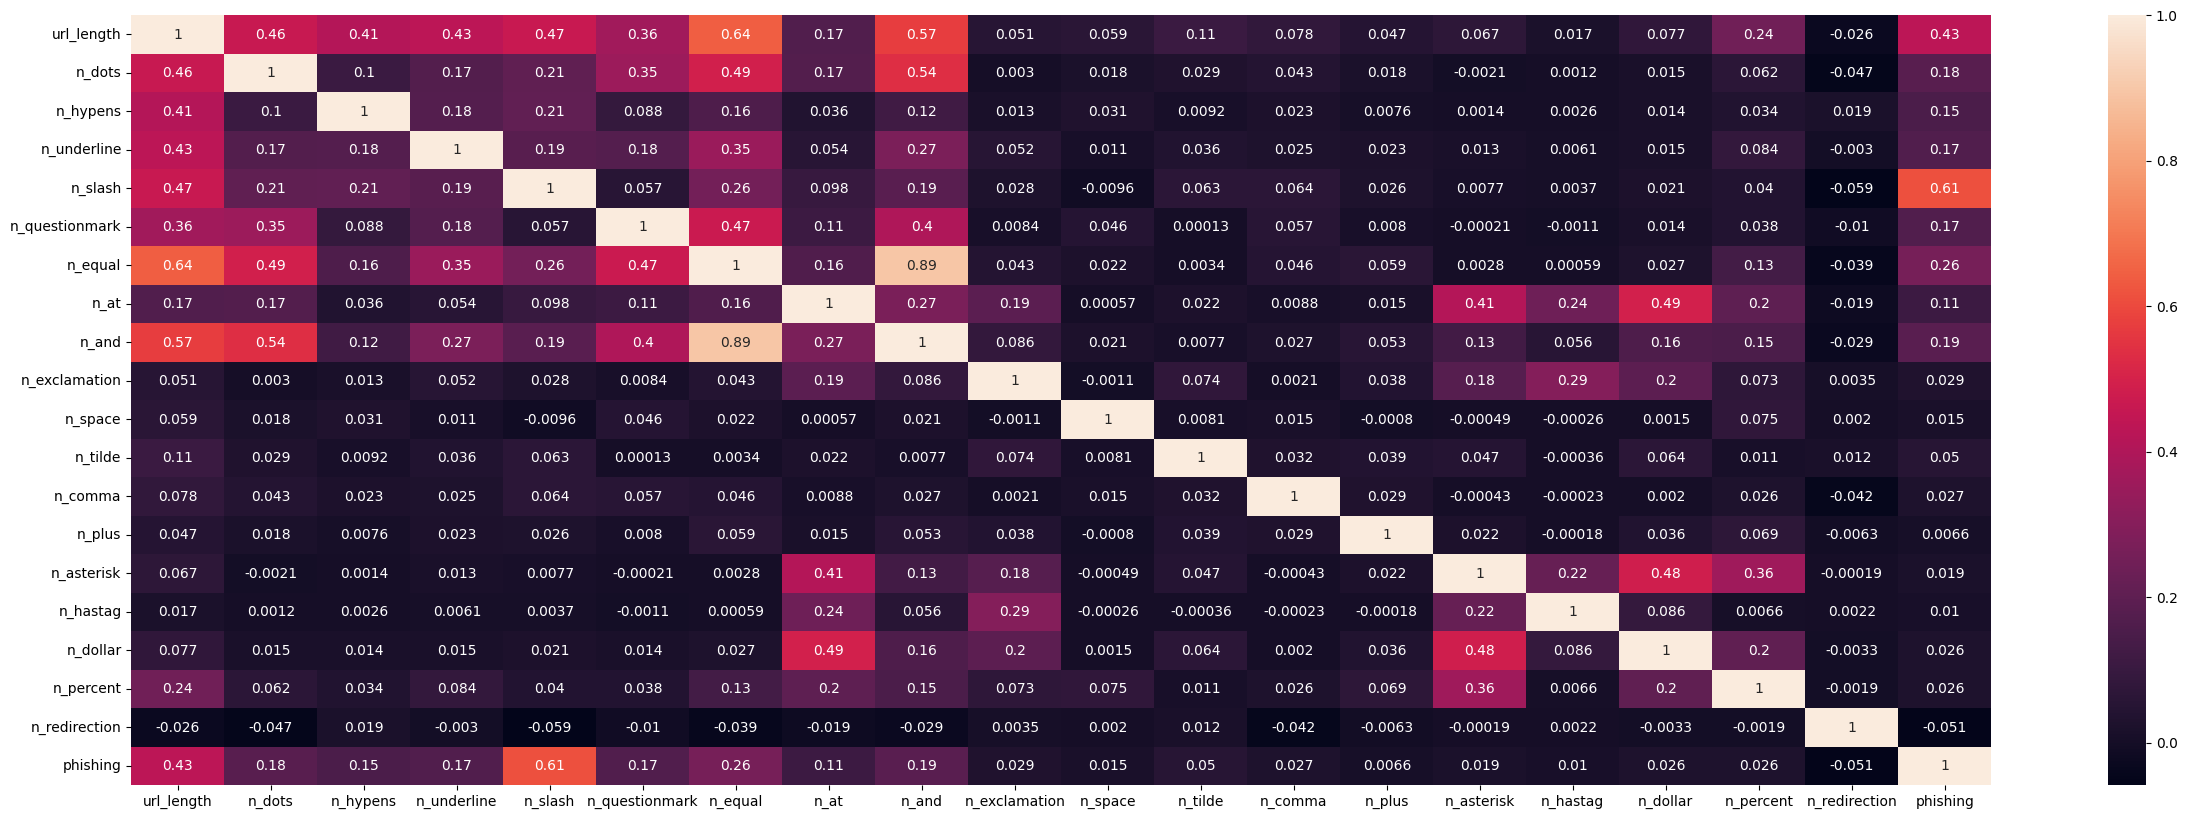

In [8]:
plt.figure(figsize=(30,10))
ax = sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.show()

In [9]:
plt.style.use('ggplot')
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [10]:
X = df.drop('phishing', axis=1)
y = df['phishing']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Modeller

In [11]:
model_list = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(n_neighbors=3),
    RandomForestClassifier(n_estimators=100),
    GradientBoostingClassifier(n_estimators=100),
    AdaBoostClassifier(n_estimators=100),
    MLPClassifier(hidden_layer_sizes=(100,), max_iter=300),
    GaussianNB()
]

In [12]:
results = []

In [13]:
for i, model in enumerate(model_list):
    print(f"Training model - {str(model)}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    results.append({
        "Model": model,
        "Accuracy": accuracy,
        "Precision (0)": report['0']['precision'],
        "Recall (0)": report['0']['recall'],
        "F1-score (0)": report['0']['f1-score'],
        "Precision (1)": report['1']['precision'],
        "Recall (1)": report['1']['recall'],
        "F1-score (1)": report['1']['f1-score']
    })

Training model - LogisticRegression()
Training model - DecisionTreeClassifier()
Training model - KNeighborsClassifier(n_neighbors=3)
Training model - RandomForestClassifier()
Training model - GradientBoostingClassifier()
Training model - AdaBoostClassifier(n_estimators=100)
Training model - MLPClassifier(max_iter=300)
Training model - GaussianNB()


End of Training


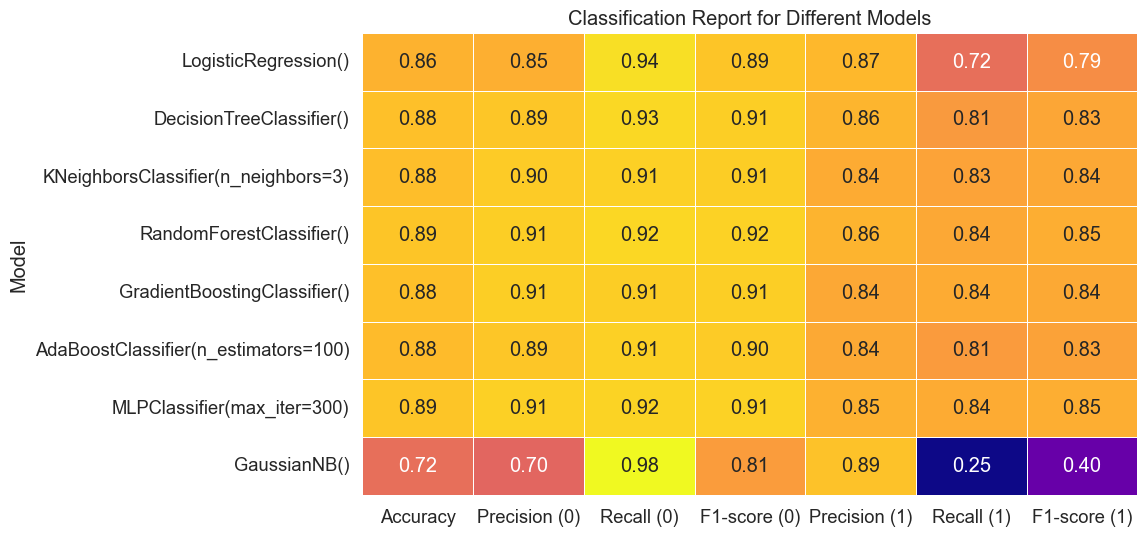

In [14]:
print("End of Training")
sns.set(font_scale=1.2)
plt.figure(figsize=(10, 6))
table = sns.heatmap(pd.DataFrame(results).set_index('Model'), annot=True, cmap="plasma", fmt=".2f", linewidths=.5, cbar=False)
plt.title("Classification Report for Different Models")
plt.show()

EN İYİ MODEL f1 Scoruna Göre

In [15]:
for model in results:
    model["F1-score Avg"] = (model["F1-score (0)"] + model["F1-score (1)"]) / 2

sorted_models = sorted(results, key=lambda x: x["F1-score Avg"], reverse=True)
best_model = sorted_models[0]

print(f"Most suitable model: {str(best_model['Model'].__class__.__name__)} - F1 Score Avg: {str(best_model['F1-score Avg'])}")

Most suitable model: RandomForestClassifier - F1 Score Avg: 0.8823642063909922


In [16]:
from joblib import dump, load

dump(best_model['Model'], 'best_model.joblib')

['best_model.joblib']

TEST CROSS_VALİD

In [ ]:
CrossValidResult = []

# Her model için çapraz doğrulama sonuçları (10x olarak belirledik)
for model in model_list:
    cv_results = cross_validate(model, X, y, cv=10,
                                scoring={'precision': 'precision',
                                         'recall': 'recall',
                                         'f1': 'f1',
                                         'accuracy': 'accuracy',
                                         'roc_auc': 'roc_auc',
                                         'average_precision': 'average_precision',
                                         'neg_brier_score': 'neg_brier_score'})

    model_results = {
        'Model': type(model).__name__,
        'Precision': cv_results['test_precision'].mean(),
        'Recall': cv_results['test_recall'].mean(),
        'F1': cv_results['test_f1'].mean(),
        'Accuracy': cv_results['test_accuracy'].mean(),
        'ROC AUC': cv_results['test_roc_auc'].mean(),
        'Average Precision': cv_results['test_average_precision'].mean(),
        'Neg Brier Score': cv_results['test_neg_brier_score'].mean()
    }

    CrossValidResult.append(model_results)

CrossValidResult_df = pd.DataFrame(CrossValidResult)
print(CrossValidResult_df)